# Shortcut Connection 성능 비교
> 잃어버렸던 결과를 얼마나 보강할 수 있는지 확인하고자 함

> shortcut 적용한 모델과 적용하지 않은 모델 비교

> feature map 비교를 통해 진행하고자 함

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [44]:
# BasicBlock
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1, use_shortcut = True):
        super(BasicBlock, self).__init__()
        
        self.use_shortcut = use_shortcut

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)

        if self.use_shortcut:
            self.shortcut = nn.Sequential()
            if stride != 1 or in_planes != planes:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                    nn.BatchNorm2d(planes)
                )
        else:
            self.shortcut = None

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.use_shortcut:
            out += self.shortcut(x)
        return F.relu(out)

# ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes = 10, use_shortcut = True):
        super(ResNet, self).__init__()
        
        self.in_planes = 64
        self.use_shortcut = use_shortcut

        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride = 2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_planes, planes, stride if i == 0 else 1, self.use_shortcut))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Files already downloaded and verified


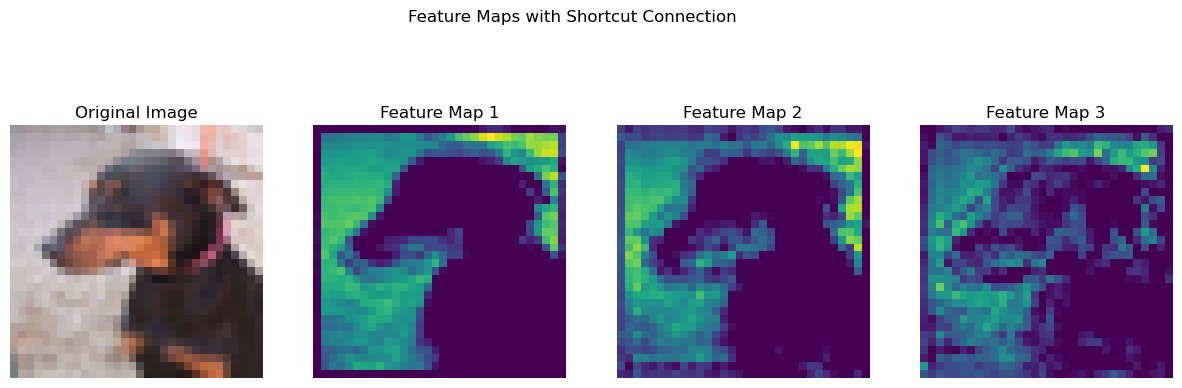

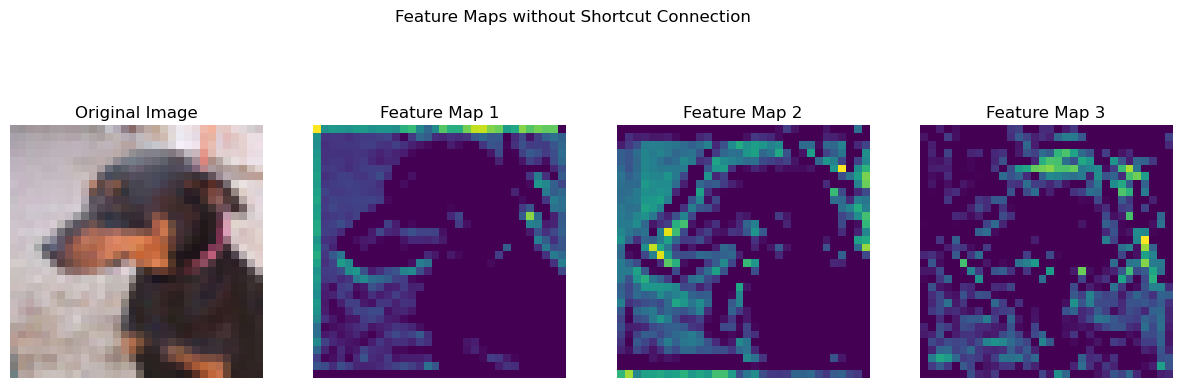

In [58]:
# use CIFAR-10
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle = True)

def visualize_feature_maps(model, input_image):
    with torch.no_grad():
        feature_maps = []
        x = input_image
        x = F.relu(model.bn1(model.conv1(x)))
        feature_maps.append(x)

        for layer in model.layer1:
            x = layer(x)
            feature_maps.append(x)

        return feature_maps


data_iter = iter(train_loader)
image, label = next(data_iter)

model_with_shortcut = ResNet(BasicBlock, [2, 2, 2, 2], use_shortcut = True)
model_without_shortcut = ResNet(BasicBlock, [2, 2, 2, 2], use_shortcut = False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_with_shortcut.to(device)
model_without_shortcut.to(device)

image = image.to(device)

feature_maps_with_shortcut = visualize_feature_maps(model_with_shortcut, image)
feature_maps_without_shortcut = visualize_feature_maps(model_without_shortcut, image)

def plot_images(original_image, feature_maps, title):
    plt.figure(figsize = (15, 5))
    plt.subplot(1, len(feature_maps) + 1, 1)
    plt.imshow(original_image.permute(1, 2, 0).cpu().numpy())
    plt.title("Original Image")
    plt.axis('off')

    for i, fmap in enumerate(feature_maps):
        plt.subplot(1, len(feature_maps) + 1, i + 2)
        plt.imshow(fmap[0, 0].cpu().numpy(), cmap = 'viridis')
        plt.title(f"Feature Map {i + 1}")
        plt.axis('off')
    
    plt.suptitle(title)
    plt.show()

plot_images(image[0], feature_maps_with_shortcut, "Feature Maps with Shortcut Connection")
plot_images(image[0], feature_maps_without_shortcut, "Feature Maps without Shortcut Connection")